# Title of the Notebook

## Business Understanding

explaination of where data is coming

cleaning section

## Data Understanding (Results Page)

## Conclusions Section

In [167]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import bs4
import lxml
import csv
from rotten_tomatoes_scraper.rt_scraper import MovieScraper
%matplotlib inline

In [286]:
bom_df          = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')
tn_df           = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
rt_info_df      = pd.read_csv('../zippedData/rt.movie_info.tsv.gz', delimiter='\t', encoding='iso8859_1')
rt_reviews_df   = pd.read_csv('../zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='iso8859_1')
# data_imdbr = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
# data_imdbb = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
# data_imdbn = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
# data_imdbc = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
# data_imdbp = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
# data_imdba = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
# data_tmdb  = pd.read_csv('zippedData/tmdb.movies.csv.gz')

In [287]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


# Box Office Mojo

## -----------------------------------Cleaning-------------------------------------
### In the cells below, the data is being cleaned for empty cells in studio and summing the total grossing amount to total domestic and foreign and dropping the domestic and foreign columns.

clean out empty rows in studio column and set to new variable.

In [288]:
bom_clean = bom_df[bom_df['studio'].notna()]

Dropping commas and converting foreign to float.

In [289]:
bom_clean['foreign_gross'] = bom_clean['foreign_gross'].str.replace(',','').astype(float)

<ipython-input-289-9d1896d0b027>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bom_clean['foreign_gross'] = bom_clean['foreign_gross'].str.replace(',','').astype(float)


Adding the foreign and domestic gross to total_gross column.

In [290]:
bom_clean['total_gross'] = bom_clean.fillna(0)['domestic_gross'] + bom_clean.fillna(0)['foreign_gross']

<ipython-input-290-2e853af365ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bom_clean['total_gross'] = bom_clean.fillna(0)['domestic_gross'] + bom_clean.fillna(0)['foreign_gross']


Dropping the domestic and foreign columns 

In [291]:
bom_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 0 to 3386
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3382 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3356 non-null   float64
 3   foreign_gross   2033 non-null   float64
 4   year            3382 non-null   int64  
 5   total_gross     3382 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 185.0+ KB


In [292]:
title_counts = bom_clean['title'].value_counts() > 1

In [293]:
title_counts[title_counts.values == True]

Bluebeard    True
Name: title, dtype: bool

In [294]:
bom_clean.reset_index(inplace=True)

In [326]:
bom_clean['studio'].replace('WB (NL)','WB',inplace=True)
bom_clean['studio'].replace('FoxS','Fox',inplace=True)

C:\Users\ajche\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Setting variable for to 1k movies

## ---------------------------Exploratory Data Analysis----------------------------

### Making a plot of the movie count per production company of the top 1000 grossing movies

In [327]:
studio_movie_count = bom_clean.groupby('studio').count()['title']
studio_top_grossing = bom_clean.groupby('studio').sum()['total_gross']

In [328]:
avg_gross_per_movie = studio_top_grossing/studio_movie_count

In [329]:
avg_gross_per_movie.sort_values(ascending=False)

studio
HC            8.703000e+08
P/DW          5.076500e+08
BV            4.171027e+08
GrtIndia      2.542000e+08
WB            2.225440e+08
                  ...     
BSM           5.100000e+03
TAFC          4.600000e+03
Hiber         3.600000e+03
ALP           2.800000e+03
Synergetic    2.400000e+03
Length: 255, dtype: float64

<BarContainer object of 20 artists>

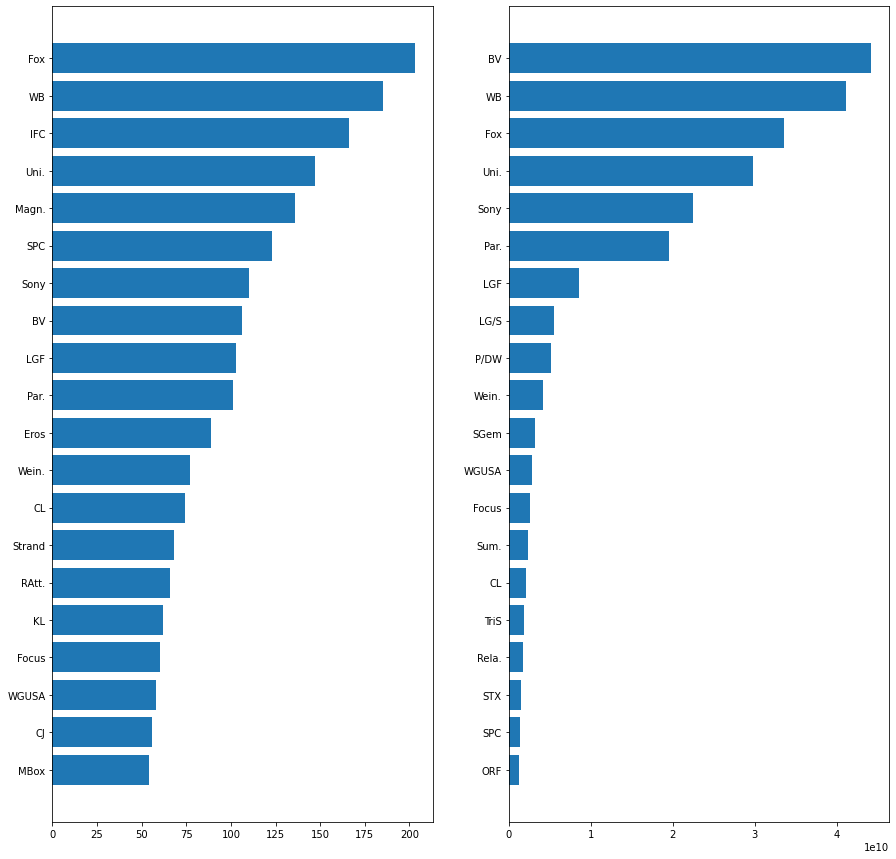

In [330]:
fig , ax = plt.subplots(1,2,figsize=(15,15))
ax[1].barh(studio_top_grossing.sort_values(ascending=False).head(20).sort_values(ascending=True).index,studio_top_grossing.sort_values(ascending=False).head(20).sort_values(ascending=True).values)
ax[0].barh(studio_movie_count.sort_values(ascending=False).head(20).sort_values(ascending=True).index,studio_movie_count.sort_values(ascending=False).head(20).sort_values(ascending=True).values)


Out of the top 1000 grossing movies in the data set, this is a bar graph showing the number of movies by production company. The big players in the film industry in terms of sheer numbers are universal, Fax, warner brothers, Walt Disney, Soney, Paramount, and Lionsgate.

TODO: match these values with the production cost.


## Bar Chart of the average grossing income per movie made within the years 2010-2018 top 20.

<BarContainer object of 20 artists>

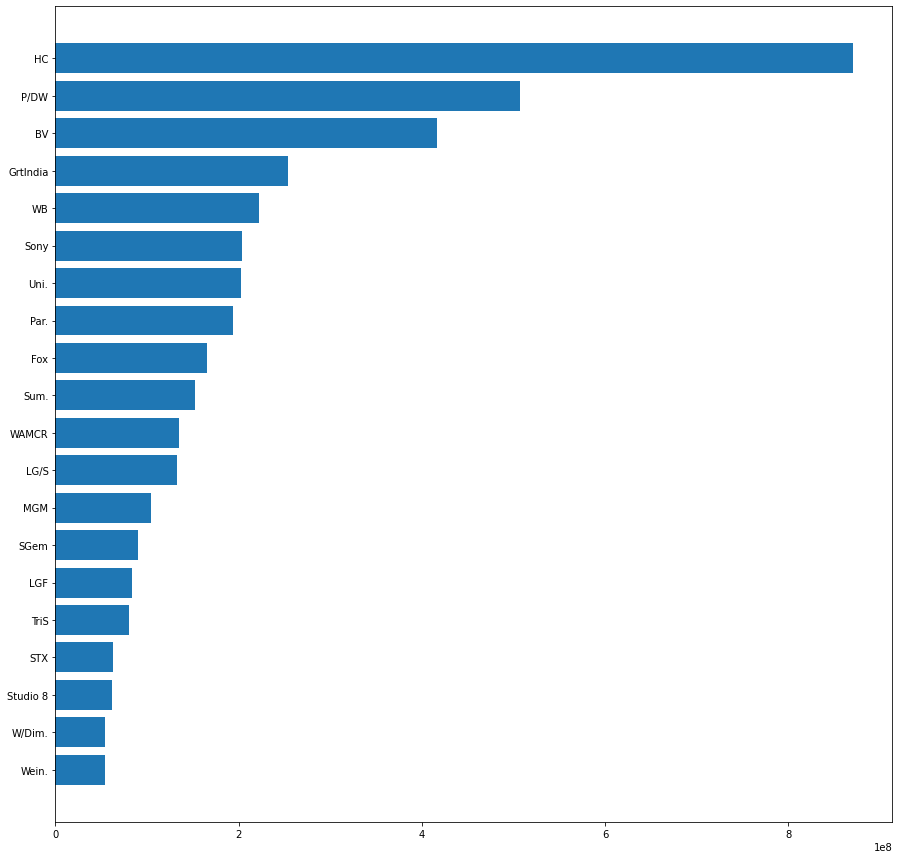

In [331]:
fig,ax = plt.subplots(figsize=(15,15))
ax.barh(avg_gross_per_movie.sort_values(ascending=False).head(20).sort_values(ascending=True).index\
    ,avg_gross_per_movie.sort_values(ascending=False).head(20).sort_values(ascending=True).values)

### Find out who P/DW studios are and emulate their business model.

In [285]:
bom_clean[bom_clean['studio'] == 'P/DW']

,title,studio,year,total_gross
4,Shrek Forever After,P/DW,2010,7.526000e+08
9,How to Train Your Dragon,P/DW,2010,4.949000e+08
17,Megamind,P/DW,2010,3.219000e+08
71,Dinner for Schmucks,P/DW,2010,8.680000e+07
328,Transformers: Dark of the Moon,P/DW,2011,1.123800e+09
332,Kung Fu Panda 2,P/DW,2011,6.656000e+08
337,Puss in Boots,P/DW,2011,5.550000e+08
732,Madagascar 3: Europe's Most Wanted,P/DW,2012,7.469000e+08
750,Rise of the Guardians,P/DW,2012,3.069000e+08
863,A Thousand Words,P/DW,2012,2.210000e+07


IFC: IFC Films
Uni.: Universal
WB: Warner Brothers
Magn.: Magnolia Studios
Fox: Fox
SPC: Sony Pictures Classics
Sony: Sony Productions
BV: Disney
LGF: Lionsgate
Par.: Paramount
Eros: Eros International Media Ltd. (India Studio)
Wein.: The Weinstein Company
CL: ?
Strand: Strand Studios(Animated Movies)
FoxS: part of The Walt Disney Company (India)


# Rotten Tomatoes

## Data Cleaning

In [38]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [39]:
rt_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         1552 non-null   int64 
 1   id            1552 non-null   int64 
 2   synopsis      1495 non-null   object
 3   rating        1552 non-null   object
 4   genre         1552 non-null   object
 5   director      1360 non-null   object
 6   writer        1110 non-null   object
 7   theater_date  1201 non-null   object
 8   dvd_date      1201 non-null   object
 9   currency      340 non-null    object
 10  box_office    340 non-null    object
 11  runtime       1526 non-null   object
 12  studio        494 non-null    object
dtypes: int64(2), object(11)
memory usage: 157.8+ KB


In [40]:
rt_info.dropna(subset=['genre'],inplace=True)
rt_info.reset_index(inplace=True)

# THE NUMBERS


## Data Cleaning

In [308]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [309]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [310]:
tn_df['release_date'] = pd.DatetimeIndex(the_numbers['release_date'])

In [311]:
tn_df['domestic_gross'] = tn_df['domestic_gross'].str.replace(',','')
tn_df['domestic_gross'] = tn_df['domestic_gross'].str.replace('$','')
tn_df['domestic_gross'] = tn_df['domestic_gross'].astype(float)

In [312]:
tn_df['production_budget'] = tn_df['production_budget'].str.replace(',','')
tn_df['production_budget'] = tn_df['production_budget'].str.replace('$','')
tn_df['production_budget'] = tn_df['production_budget'].astype(float)

In [313]:
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].str.replace(',','')
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].str.replace('$','')
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].astype(float)

In [314]:
tn_df['year'] = tn_df['release_date'].dt.year

In [315]:
tn_df['month'] = tn_df['release_date'].dt.month

In [316]:
tn_df['day'] = tn_df['release_date'].dt.dayofweek

## Exploratory Data Analysis

## What is the worldwide gross with the month of the year? Maybe rolling out new original content should match the month of the year

In [215]:
month_map = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December' }
day_map = {0 : 'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

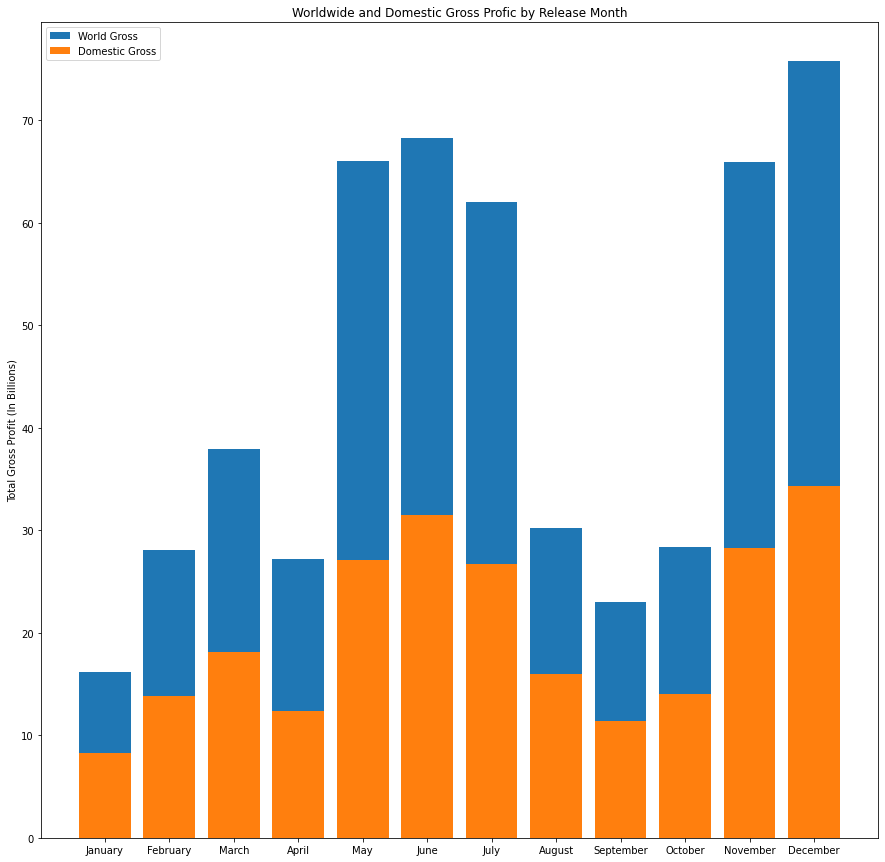

In [227]:
fig,ax = plt.subplots(figsize = (15,15))
ax.bar(month_map.values(),tn_df.groupby('month').sum()['worldwide_gross'].values/1000000000)
ax.bar(month_map.values(),tn_df.groupby('month').sum()['domestic_gross'].values/1000000000)
ax.set_title('Worldwide and Domestic Gross Profic by Release Month')
ax.set_ylabel('Total Gross Profit (In Billions)')
ax.legend(['World Gross','Domestic Gross'],loc='upper left')

## What is the worldwide and domestic gross by the day of the week. Maybe rolling out new movies or episodes on Friday would be better than rolling out in the middle of the week.

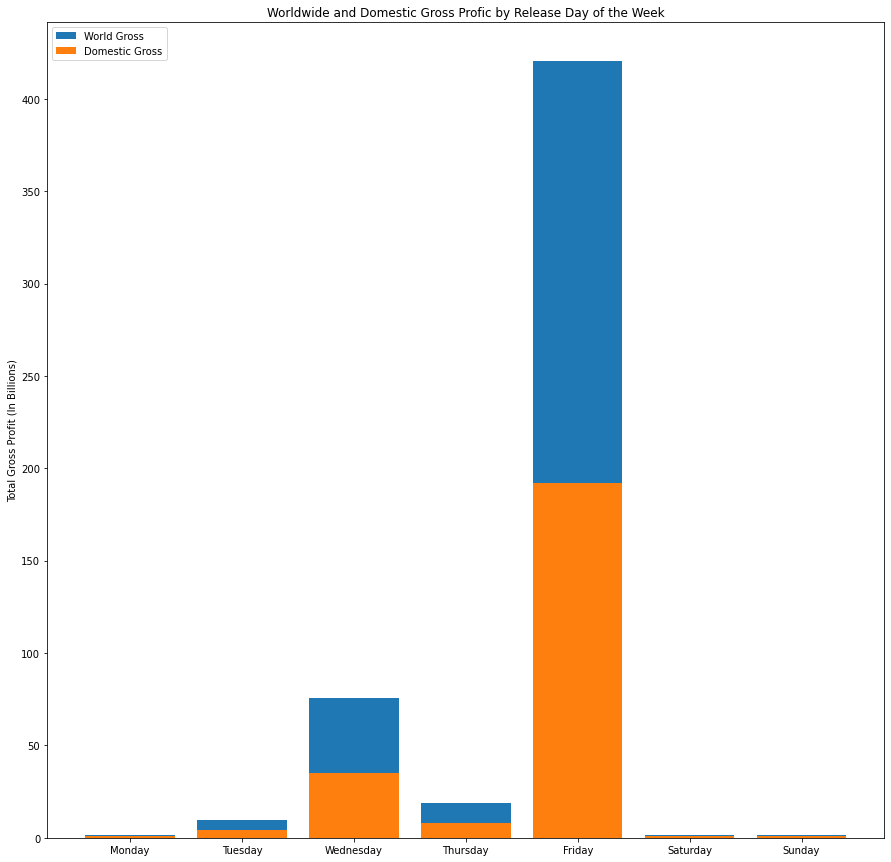

In [229]:
fig,ax = plt.subplots(figsize = (15,15))
ax.bar(day_map.values(),tn_df.groupby('day').sum()['worldwide_gross'].values/1000000000)
ax.bar(day_map.values(),tn_df.groupby('day').sum()['domestic_gross'].values/1000000000)
ax.set_title('Worldwide and Domestic Gross Profic by Release Day of the Week')
ax.set_ylabel('Total Gross Profit (In Billions)')
ax.legend(['World Gross','Domestic Gross'],loc='upper left')

In [332]:
bom_tojoin = bom_clean.set_index('title')
tn_tojoin = tn_df.set_index('movie')

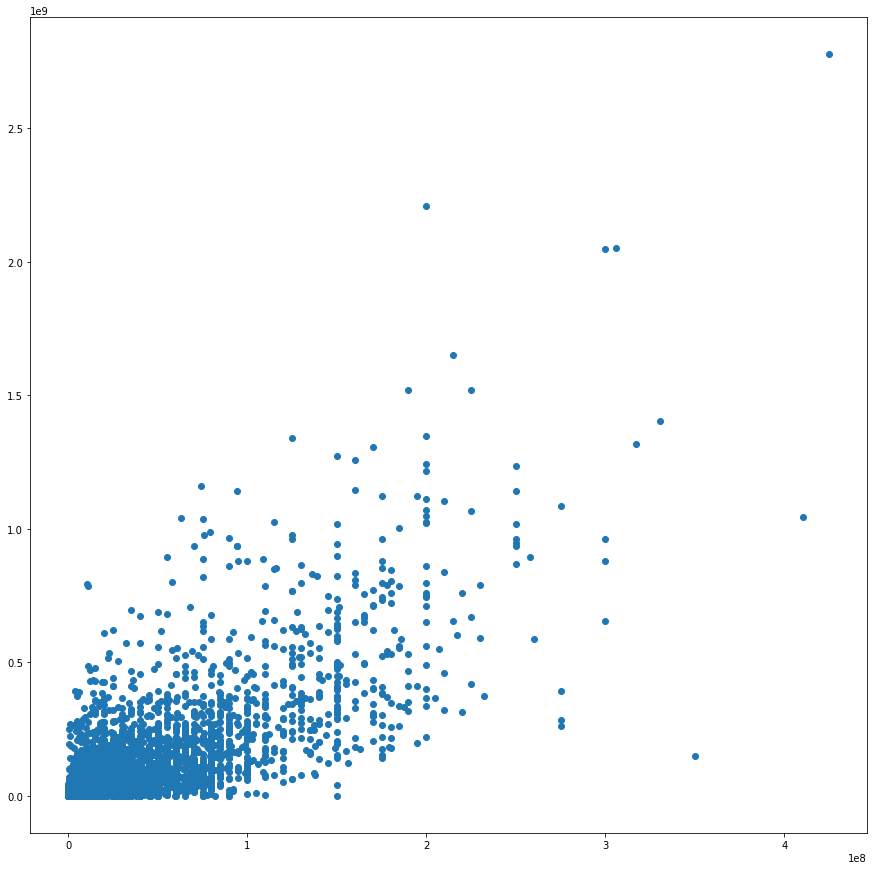

In [424]:
fig,ax = plt.subplots(figsize=(15,15))
ax.scatter(tn_df['production_budget'],tn_df['worldwide_gross'])

## Running correlation between budget of a movie and it's grossing income.

In [402]:
print('Correlation between budget and gross')
pd.DataFrame([{'world':tn_df['worldwide_gross'].corr(tn_df['production_budget'])},\
{'domestic':tn_df['domestic_gross'].corr(tn_df['production_budget'])}]).T

Correlation between budget and gross


,0,1
world,0.748306,NaN
domestic,NaN,0.685682


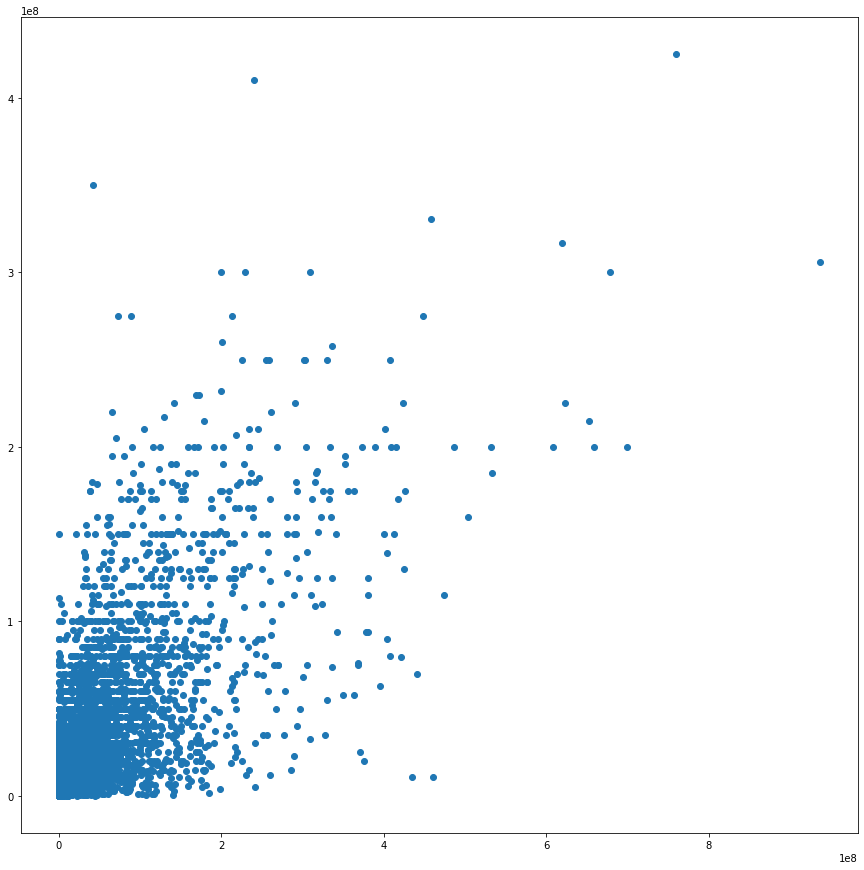

In [392]:
fig,ax = plt.subplots(figsize=(15,15))
ax.scatter(tn_df['domestic_gross'],tn_df['production_budget'])

In [333]:
tn_bom_joined = bom_tojoin.join(tn_tojoin,how='inner',lsuffix='_1')

In [334]:
tn_bom_joined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1246 entries, 10 Cloverfield Lane to mother!
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              1246 non-null   int64         
 1   studio             1246 non-null   object        
 2   domestic_gross_1   1244 non-null   float64       
 3   foreign_gross      1085 non-null   float64       
 4   year_1             1246 non-null   int64         
 5   total_gross        1246 non-null   float64       
 6   id                 1246 non-null   int64         
 7   release_date       1246 non-null   datetime64[ns]
 8   production_budget  1246 non-null   float64       
 9   domestic_gross     1246 non-null   float64       
 10  worldwide_gross    1246 non-null   float64       
 11  year               1246 non-null   int64         
 12  month              1246 non-null   int64         
 13  day                1246 non-null   int64       

In [337]:
tn_bom_joined['studio'].unique()

array(['Par.', 'WB', 'Fox', 'RTWC', 'Uni.', 'Sony', 'Rela.', 'Anch.',
       'Sum.', 'STX', 'SPC', 'A24', 'ORF', 'RAtt.', 'MNE', 'Focus', 'LGF',
       'Cleopatra', 'P/DW', 'BG', 'BV', 'UTV', 'NM', 'IFC', 'Kino',
       'LG/S', 'Magn.', 'Affirm', 'Studio 8', 'CE', 'VE', 'P4', 'W/Dim.',
       'SGem', 'Wein.', 'GrtIndia', 'BSC', 'TriS', 'Eros', 'CBS', 'ALP',
       'Over.', 'ParV', 'ATO', 'NFC', 'Cohen', 'PNT', 'MGM', 'BST', 'FD',
       'Annapurna', 'Yash', 'PFR', 'OMNI/FSR', 'Free', 'Drft.', 'ENTMP',
       'Gold.', 'WHE', 'IM', 'Global Road', 'Orch.', 'Neon', 'MBox',
       'BH Tilt', 'DR', 'LD', 'Relbig.', 'LGP', 'Jan.', 'First', 'Viv.',
       'Mont.', 'RLJ', 'Osci.', 'PH', 'EC', 'CJ', 'Trib.', 'SMod', 'IVP',
       '3D', 'TFA', 'Alc', 'Amazon', 'ELS', 'Scre.', 'Strand', 'Saban',
       'EOne', 'IW', 'App.', 'GK', 'Mira.', 'BBC', 'FCW', 'KE'],
      dtype=object)

In [350]:
disney_movies = tn_bom_joined[tn_bom_joined['studio'] == 'BV']
disney_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, A Wrinkle in Time to Zootopia
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              72 non-null     int64         
 1   studio             72 non-null     object        
 2   domestic_gross_1   72 non-null     float64       
 3   foreign_gross      70 non-null     float64       
 4   year_1             72 non-null     int64         
 5   total_gross        72 non-null     float64       
 6   id                 72 non-null     int64         
 7   release_date       72 non-null     datetime64[ns]
 8   production_budget  72 non-null     float64       
 9   domestic_gross     72 non-null     float64       
 10  worldwide_gross    72 non-null     float64       
 11  year               72 non-null     int64         
 12  month              72 non-null     int64         
 13  day                72 non-null     int64         


,index,domestic_gross_1,foreign_gross,year_1,total_gross,id,production_budget,domestic_gross,worldwide_gross,year,month
day,,,,,,,,,,,
1,1157,8.930000e+07,1.712000e+08,2013,2.605000e+08,13,2.750000e+08,8.930212e+07,2.600021e+08,2013,7
2,11759,1.390800e+09,2.075600e+09,20130,3.466400e+09,419,1.192500e+09,1.390637e+09,3.437309e+09,20130,93
3,1589,1.474000e+08,1.483000e+08,4024,2.957000e+08,79,1.362000e+08,1.474247e+08,2.999039e+08,4024,16
4,94784,1.121950e+10,1.661574e+10,116823,2.783524e+10,2366,7.777100e+09,1.121890e+10,2.913199e+10,116823,395
6,366,7.990000e+07,9.770000e+07,2011,1.776000e+08,12,7.000000e+07,7.988336e+07,1.568155e+08,2011,12


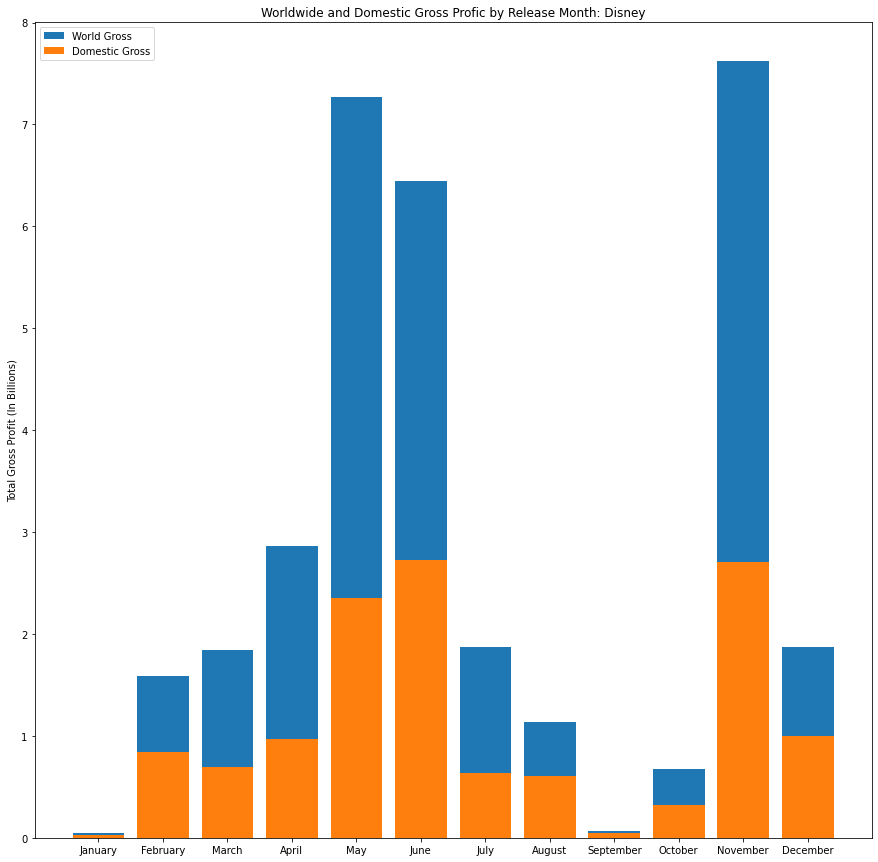

In [346]:
fig,ax = plt.subplots(figsize = (15,15))
ax.bar(month_map.values(),disney_movies.groupby('month').sum()['worldwide_gross'].values/1000000000)
ax.bar(month_map.values(),disney_movies.groupby('month').sum()['domestic_gross'].values/1000000000)
ax.set_title('Worldwide and Domestic Gross Profic by Release Month: Disney')
ax.set_ylabel('Total Gross Profit (In Billions)')
ax.legend(['World Gross','Domestic Gross'],loc='upper left')



### It looks like Disney will mainly release movies at the beginning of Summer and in November for christmas movies. Following the general trend.

In [385]:
gross_by_day = disney_movies.groupby('day').sum()

In [386]:
gross_by_day

,index,domestic_gross_1,foreign_gross,year_1,total_gross,id,production_budget,domestic_gross,worldwide_gross,year,month
day,,,,,,,,,,,
1,1157,8.930000e+07,1.712000e+08,2013,2.605000e+08,13,2.750000e+08,8.930212e+07,2.600021e+08,2013,7
2,11759,1.390800e+09,2.075600e+09,20130,3.466400e+09,419,1.192500e+09,1.390637e+09,3.437309e+09,20130,93
3,1589,1.474000e+08,1.483000e+08,4024,2.957000e+08,79,1.362000e+08,1.474247e+08,2.999039e+08,4024,16
4,94784,1.121950e+10,1.661574e+10,116823,2.783524e+10,2366,7.777100e+09,1.121890e+10,2.913199e+10,116823,395
6,366,7.990000e+07,9.770000e+07,2011,1.776000e+08,12,7.000000e+07,7.988336e+07,1.568155e+08,2011,12


In [417]:
worldGross_by_day = gross_by_day['worldwide_gross'].append(pd.Series([0,0],index=[0,5])).sort_index()

In [418]:
domestGross_by_day = gross_by_day['domestic_gross'].append(pd.Series([0,0],index=[0,5])).sort_index()

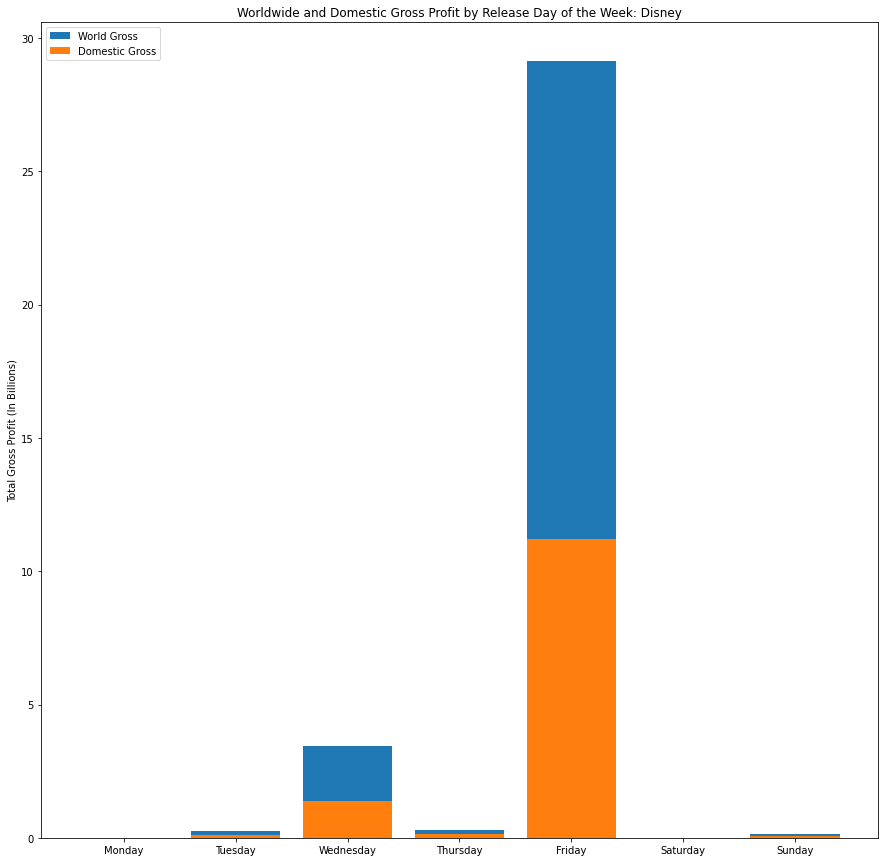

In [422]:
fig,ax = plt.subplots(figsize = (15,15))
ax.bar(day_map.values(),worldGross_by_day.values/1000000000)
ax.bar(day_map.values(),domestGross_by_day.values/1000000000)
ax.set_title('Worldwide and Domestic Gross Profit by Release Day of the Week: Disney')
ax.set_ylabel('Total Gross Profit (In Billions)')
ax.legend(['World Gross','Domestic Gross'],loc='upper left')